In [1]:
from langchain_core.messages import AnyMessage
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List, Annotated, Literal, Union, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.documents import Document
import re
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain.document_loaders import TextLoader


c:\Users\sogno\AppData\Local\pypoetry\Cache\virtualenvs\langchain-basic-farQSE-J-py3.12\Lib\site-packages\IPython\core\interactiveshell.py:3672: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
)

In [3]:
# 메뉴판 텍스트 데이터를 로드
loader = TextLoader("../data/cafe_menu_data.txt", encoding="utf-8")
documents = loader.load()

In [4]:
# Text Split (문서 분할)
def split_cafe_menu(document):
    pattern = r'(\d+\.\s.*?)(?=\n\n\d+\.|$)'
    menu_items = re.findall(pattern, document.page_content, re.DOTALL)
    
    # 각 메뉴 항목을 Document 객체로 변환
    menu_documents = []
    for i, item in enumerate(menu_items, 1):
        # 메뉴 이름 추출
        menu_name = item.split('\n')[0].split('.', 1)[1].strip()
        
        price_match = re.search(r"• 가격:\s*₩([\d,]+)", item)
        price = int(price_match.group(1).replace(",", "")) if price_match else 0
        
        # 새로운 Document 객체 생성
        menu_doc = Document(
            page_content=item.strip(),
            metadata={
                "source": document.metadata['source'],
                "menu_number": i,
                "menu_name": menu_name,
                "price": price, # 가격 메타데이터 추가
            }
        )
        menu_documents.append(menu_doc)
    
    return menu_documents

menu_documents=[]
for doc in documents:
    menu_documents += split_cafe_menu(doc)
    
# 결과 출력
print(f"총 {len(menu_documents)}개의 메뉴 항목이 처리되었습니다.")
for doc in menu_documents[:2]:
    print(f"\n메뉴 번호: {doc.metadata['menu_number']}")
    print(f"메뉴 이름: {doc.metadata['menu_name']}")
    print(f"내용:\n{doc.page_content[:100]}...")

총 10개의 메뉴 항목이 처리되었습니다.

메뉴 번호: 1
메뉴 이름: 아메리카노
내용:
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 ...

메뉴 번호: 2
메뉴 이름: 카페라떼
내용:
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다...


In [5]:
embeddings_model = OllamaEmbeddings(model="bge-m3:latest") 

# FAISS 인덱스 생성
cafe_db = FAISS.from_documents(
    documents=menu_documents, 
    embedding=embeddings_model
)

# FAISS 인덱스 저장
cafe_db.save_local("./db/cafe_db")

In [6]:
# 상태 정의
class ClassifiedIntent(BaseModel):
    intent: Literal["menu_info", "price_info", "recommendation", "greeting", "unknown"] = Field(
        description="""
            사용자 문의 의도 분류:
                - 'menu_info': 특정 메뉴 또는 일반적인 메뉴 정보 문의
                - 'price_info': 메뉴 가격 문의
                - 'recommendation': 메뉴 추천 요청
                - 'greeting': 단순 인사
                - 'unknown': 위 분류에 해당하지 않는 경우
        """
    )
    menu_name: Union[str, None] = Field(
        description="사용자가 언급한 특정 메뉴 이름 (없으면 null)"
    )

class GraphState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages] # langgraph.graph.message.add_messages 사용
    classified_intent: Union[ClassifiedIntent, None]

In [7]:

# 질문 분류 로직
classification_prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(content="""
        당신은 사용자 문의의 의도를 분류하는 AI입니다. 사용자의 마지막 메시지를 분석하여 다음 분류 중 하나로 답변하고, 언급된 메뉴 이름도 함께 알려주세요:
            - 'menu_info': 특정 메뉴 또는 일반적인 메뉴 정보 문의 (예: "아메리카노 있나요?", "커피 종류 뭐 있어요?")
            - 'price_info': 메뉴 가격 문의 (예: "아메리카노 얼마예요?", "가격 알려줘")
            - 'recommendation': 메뉴 추천 요청 (예: "뭐가 맛있어요?", "커피 추천해주세요")
            - 'greeting': 단순 인사 (예: "안녕하세요")
            - 'unknown': 위 분류에 해당하지 않는 경우.
        사용자가 특정 메뉴를 언급했다면 menu_name 필드에 해당 메뉴 이름을 포함하세요.
        """
    ),
    HumanMessage(content="사용자 문의: {user_query}")
])

In [8]:
# --- 정보 추출 함수 ---
def extract_menu_info(doc: Document) -> dict:
    content = doc.page_content
    menu_name = doc.metadata.get('menu_name', '알 수 없음')
    price = doc.metadata.get('price', 0) # 숫자형으로 저장했으므로
    category = doc.metadata.get('category', '미분류')

    # page_content에서 설명만 추출 (메타데이터에 이미 있으므로 중복될 수 있음)
    description_match = re.search(r'설명:\s*([\s\S]+?)(?:\n키워드:|\Z)', content, re.DOTALL)
    description = description_match.group(1).strip() if description_match else "설명 없음"
    
    return {
        "name": menu_name,
        "price": f"₩{price:,}" if price > 0 else "가격 정보 없음", # 출력 시 포맷팅
        "category": category,
        "description": description
    }

In [9]:
# --- 문의 분류 로직 (노드) ---
# Gemini는 JSON 출력 형식을 잘 따르도록 프롬프트에 명시하는 것이 중요
# with_structured_output이 OpenAI 모델만큼 안정적이지 않을 수 있음
# ClassifiedIntent Pydantic 모델을 사용
structured_llm_classifier = llm.with_structured_output(ClassifiedIntent, include_raw=False)

def classify_user_query_node(state: GraphState) -> dict:
    print("\n--- 노드: 사용자 문의 분류 중... ---")
    user_message = state["messages"][-1].content
    
    # 간단한 키워드 기반 우선 처리
    if any(keyword in user_message.lower() for keyword in ["안녕", "하이", "헬로", "반가워"]):
        print("키워드 기반 분류: greeting")
        classified_info = ClassifiedIntent(intent="greeting", menu_name=None)
    elif "메뉴판" in user_message or "메뉴 뭐 있어" in user_message or "메뉴 좀" in user_message :
         print("키워드 기반 분류: menu_info (전체 메뉴)")
         classified_info = ClassifiedIntent(intent="menu_info", menu_name=None) # 전체 메뉴로 간주
    else:
        print(f"LLM으로 '{user_message}' 분류 시도...")
        prompt_messages_for_classification = [
            SystemMessage(content=f"다음은 사용자의 의도를 분류하기 위한 JSON 스키마입니다:\n \
                          {ClassifiedIntent.schema_json(indent=2)}\n\n사용자 메시지를 분석하여 이 스키마에 따라 의도를 분류하고, 언급된 메뉴 이름을 찾아주세요."),
            HumanMessage(content=user_message)
        ]
        try:
            # structured_llm_classifier 사용
            classified_info = structured_llm_classifier.invoke(prompt_messages_for_classification)
            print(f"LLM 분류 결과: {classified_info}")
        except Exception as e:
            print(f"LLM 분류 중 오류 발생: {e}. 'unknown'으로 처리합니다.")
            # 오류 내용에 따라 파싱 로직 추가 또는 프롬프트 수정 고려
            if "response was blocked" in str(e).lower():
                 print("Gemini 응답이 안전 설정에 의해 차단되었을 수 있습니다.")
            classified_info = ClassifiedIntent(intent="unknown", menu_name=None)
            
    return {"classified_intent": classified_info}


In [ ]:
# --- 응답 생성 함수들 (노드) ---
def format_docs_for_llm(docs: List[Document]) -> str:
    if not docs: return "관련 정보를 찾을 수 없습니다."
    return "\n\n".join([f"{i+1}. 메뉴명: {extract_menu_info(doc)['name']}\n   가격: {extract_menu_info(doc)['price']}\n   카테고리: {extract_menu_info(doc)['category']}\n   설명: {extract_menu_info(doc)['description']}" for i, doc in enumerate(docs)])

def general_response_node(state: GraphState, task_description: str, search_k: int = 3):
    user_message_content = state["messages"][-1].content
    intent_info = state["classified_intent"]
    
    search_query = user_message_content
    if intent_info and intent_info.menu_name:
        search_query = intent_info.menu_name
        if "가격" in task_description: search_query += " 가격"

    print(f"'{search_query}'(으)로 '{task_description}' 관련 정보 검색 (k={search_k})")
    docs = cafe_db.similarity_search(search_query, k=search_k)
    
    if "추천" in task_description and (not docs or len(docs) < 2) :
        print(f"'{task_description}' 초기 검색 결과 부족. '인기 메뉴', '추천 메뉴' 추가 검색")
        # "키워드: 인기 메뉴"가 포함된 문서를 찾도록 유도
        popular_docs = cafe_db.similarity_search(f"{search_query} 인기 메뉴 추천", k=search_k) 
        if not popular_docs: # 그래도 없으면 일반 인기 메뉴
            popular_docs = cafe_db.similarity_search("인기 메뉴 추천", k=search_k)
        
        if popular_docs:
            existing_names = {extract_menu_info(doc)['name'] for doc in docs}
            for p_doc in popular_docs:
                if extract_menu_info(p_doc)['name'] not in existing_names:
                    docs.append(p_doc)
            docs = docs[:search_k]

    if not docs:
        ai_response = f"죄송합니다, 요청하신 '{task_description}' 관련 정보를 찾을 수 없었습니다."
        if "추천" in task_description:
            ai_response += " 혹시 특별히 찾으시는 스타일(예: 달콤한 커피, 상큼한 음료)이 있으신가요?"
    else:
        context_str = format_docs_for_llm(docs)
        # Gemini는 시스템 메시지를 첫 번째 Human 메시지에 포함하는 것을 선호
        # (ChatGoogleGenerativeAI(convert_system_message_to_human=True) 설정 덕분)
        full_prompt = f"""당신은 친절하고 유능한 카페 직원입니다. 고객의 요청에 대해 아래 메뉴 정보를 참고하여 답변해주세요.

                        고객 요청 유형: {task_description}
                        참고 메뉴 정보:
                        {context_str}

                        위 정보를 바탕으로 고객의 질문 "{user_message_content}"에 대해 답변해주세요."""

        if "추천" in task_description:
            full_prompt += "\n\n메뉴를 추천하고, 각 메뉴의 특징과 매력을 설명해주세요."
        if "가격" in task_description:
            full_prompt += "\n\n가격 정보를 명확하게 포함하여 답변해주세요."
        
        prompt = ChatPromptTemplate.from_messages([HumanMessage(content=full_prompt)])
        response = (prompt | llm).invoke({})
        ai_response = response.content
        
    return {"messages": [AIMessage(content=ai_response)]}

def menu_info_node(state: GraphState):
    print("--- 노드: 메뉴 정보 안내 ---")
    return general_response_node(state, "메뉴 정보", search_k=5)

def price_info_node(state: GraphState):
    print("--- 노드: 가격 정보 안내 ---")
    return general_response_node(state, "가격 정보", search_k=3)

def recommendation_node(state: GraphState):
    print("--- 노드: 메뉴 추천 ---")
    return general_response_node(state, "메뉴 추천", search_k=2)

def greeting_node(state: GraphState):
    print("--- 노드: 인사 응답 ---")
    ai_response = "안녕하세요! 저희 카페에 오신 것을 환영합니다. 무엇을 도와드릴까요? 메뉴, 가격, 추천 등 편하게 문의해주세요."
    return {"messages": [AIMessage(content=ai_response)]}

def unknown_query_node(state: GraphState):
    print("--- 노드: 알 수 없는 문의 처리 ---")
    ai_response = "죄송합니다, 문의하신 내용을 정확히 이해하지 못했습니다. 메뉴, 가격, 추천 중 어떤 정보가 필요하신가요? 아니면 다른 질문이 있으실까요?"
    return {"messages": [AIMessage(content=ai_response)]}


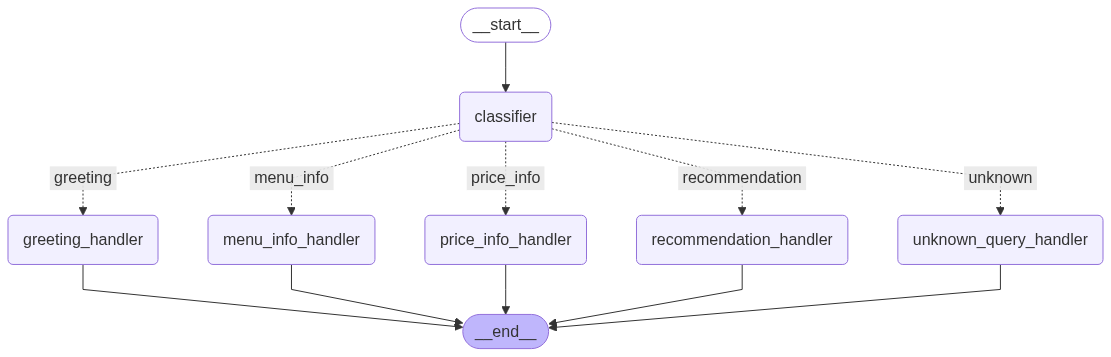

In [ ]:
from IPython.display import Image, display

# --- 그래프 구성 ---
def route_based_on_intent(state: GraphState) -> Literal["menu_info", "price_info", "recommendation", "greeting", "unknown"]:
    intent_info = state["classified_intent"]
    # classified_intent가 None일 수도 있으므로 방어적 코딩
    if intent_info and hasattr(intent_info, 'intent') and intent_info.intent:
        print(f"--- 라우팅 결정: {intent_info.intent} ---")
        return intent_info.intent
    print(f"--- 라우팅 결정: 의도 정보 없음 또는 유효하지 않음 ({intent_info}) -> unknown ---")
    return "unknown"

builder = StateGraph(GraphState)
builder.add_node("classifier", classify_user_query_node)
builder.add_node("menu_info_handler", menu_info_node)
builder.add_node("price_info_handler", price_info_node)
builder.add_node("recommendation_handler", recommendation_node)
builder.add_node("greeting_handler", greeting_node)
builder.add_node("unknown_query_handler", unknown_query_node)

builder.set_entry_point("classifier")
builder.add_conditional_edges(
    "classifier", route_based_on_intent,
    {
        "menu_info": "menu_info_handler", "price_info": "price_info_handler",
        "recommendation": "recommendation_handler", "greeting": "greeting_handler",
        "unknown": "unknown_query_handler",
    }
)

builder.add_edge("menu_info_handler", END)
builder.add_edge("price_info_handler", END)
builder.add_edge("recommendation_handler", END)
builder.add_edge("greeting_handler", END)
builder.add_edge("unknown_query_handler", END)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
from langchain_core.messages import HumanMessage

# 예시 입력 메시지
test_queries = [
	"안녕하세요",                # 인사
	"메뉴판 보여줘",             # 메뉴 정보
	"카페라떼 가격 알려줘",      # 가격 정보
	"추천 메뉴 뭐 있어?",        # 추천
	"오늘 날씨 어때?"            # 알 수 없음
]
for query in test_queries:
	print(f"\n[테스트 입력] {query}")
	test_state = {
		"messages": [HumanMessage(content=query)],
		"classified_intent": None
	}
	result = graph.invoke(test_state)
	print("[응답]", result["messages"][-1].content)
test_state = {
	"messages": [HumanMessage(content="아메리카노 가격 알려줘")],
	"classified_intent": None  # 초기에는 분류 정보가 없음
}

result = graph.invoke(test_state)
print(result["messages"][-1].content)
# app = builder.compile()


[테스트 입력] 안녕하세요

--- 노드: 사용자 문의 분류 중... ---
키워드 기반 분류: greeting
--- 라우팅 결정: greeting ---
--- 노드: 인사 응답 ---
[응답] 안녕하세요! 저희 카페에 오신 것을 환영합니다. 무엇을 도와드릴까요? 메뉴, 가격, 추천 등 편하게 문의해주세요.

[테스트 입력] 메뉴판 보여줘

--- 노드: 사용자 문의 분류 중... ---
키워드 기반 분류: menu_info (전체 메뉴)
--- 라우팅 결정: menu_info ---
--- 노드: 메뉴 정보 안내 ---
'메뉴판 보여줘'(으)로 '메뉴 정보' 관련 정보 검색 (k=3)
[응답] 안녕하세요! 저희 카페 메뉴를 안내해 드릴게요. 현재 준비된 메뉴는 다음과 같습니다.

*   **티라미수:** ₩7,500 (이탈리아 전통 디저트로 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다.)
*   **바닐라 라떼:** ₩6,000 (카페라떼에 달콤한 바닐라 시럽을 더한 인기 메뉴입니다. 바닐라의 달콤함과 커피의 쌉싸름함이 조화롭게 어우러지며, 휘핑크림 토핑으로 더욱 풍성한 맛을 즐길 수 있습니다.)
*   **프라푸치노:** ₩7,000 (에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 크리미한 질감이 특징이며, 휘핑크림을 올려 달콤함을 더했습니다. 여름철 인기 메뉴입니다.)

혹시 더 궁금하신 점이나 다른 메뉴에 대한 문의사항이 있으시면 언제든지 편하게 말씀해주세요!

[테스트 입력] 카페라떼 가격 알려줘

--- 노드: 사용자 문의 분류 중... ---
LLM으로 '카페라떼 가격 알려줘' 분류 시도...
LLM 분류 결과: intent='price_info' menu_name='카페라떼'
--- 라우팅 결정: price_info ---
--- 노드: 가격 정보 안내 ---
'카페라떼 가격'(으)로 '가격 정보' 관